In [53]:
import os
import cv2
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt
import uuid
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape,Dropout
from tensorflow.keras.applications import ResNet152V2

### Data Collection and Labeling 

In [27]:
IMAGES_PATH = 'data/images'
number_images = 15

In [28]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [29]:
!labelme

### Image Augmentation to create more data

In [30]:
import albumentations as alb

In [31]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                        keypoint_params=alb.KeypointParams(format='xy', label_fields=['class_labels']))

In [32]:
for partition in ['train', 'test', 'val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        classes = [0,0]
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
    
            if label['shapes'][0]['label']=='left_eye': 
                classes[0] = 1
                coords[0] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[1] = np.squeeze(label['shapes'][0]['points'])[1]

            if label['shapes'][0]['label']=='right_eye':
                classes[1] = 1
                coords[2] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[3] = np.squeeze(label['shapes'][0]['points'])[1]

            if len(label['shapes']) > 1:     
                if label['shapes'][1]['label'] =='left_eye': 
                    classes[0] = 1 
                    coords[0] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[1] = np.squeeze(label['shapes'][1]['points'])[1]

                if label['shapes'][1]['label'] =='right_eye': 
                    classes[1] = 1
                    coords[2] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[3] = np.squeeze(label['shapes'][1]['points'])[1]
            
            np.divide(coords, [640,480,640,480])
                
        try: 
            for x in range(120):
                keypoints = [(coords[:2]), (coords[2:])]
                augmented = augmentor(image=img, keypoints=keypoints, class_labels=['left_eye','right_eye'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image
                annotation['class'] = [0,0]
                annotation['keypoints'] = [0,0,0,0]

                if os.path.exists(label_path):
                    if len(augmented['keypoints']) > 0: 
                        for idx, cl in enumerate(augmented['class_labels']):
                            if cl == 'left_eye': 
                                annotation['class'][0] = 1 
                                annotation['keypoints'][0] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][1] = augmented['keypoints'][idx][1]
                            if cl == 'right_eye': 
                                annotation['class'][1] = 1 
                                annotation['keypoints'][2] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][3] = augmented['keypoints'][idx][1]
                                
                annotation['keypoints'] = list(np.divide(annotation['keypoints'], [450,450,450,450]))

                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### Loading Images

In [37]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [38]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [39]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [40]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

### Preparing Labels

In [41]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

In [42]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [43]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [44]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [45]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

In [46]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [47]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

In [48]:
data_samples = train.as_numpy_iterator()

In [49]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


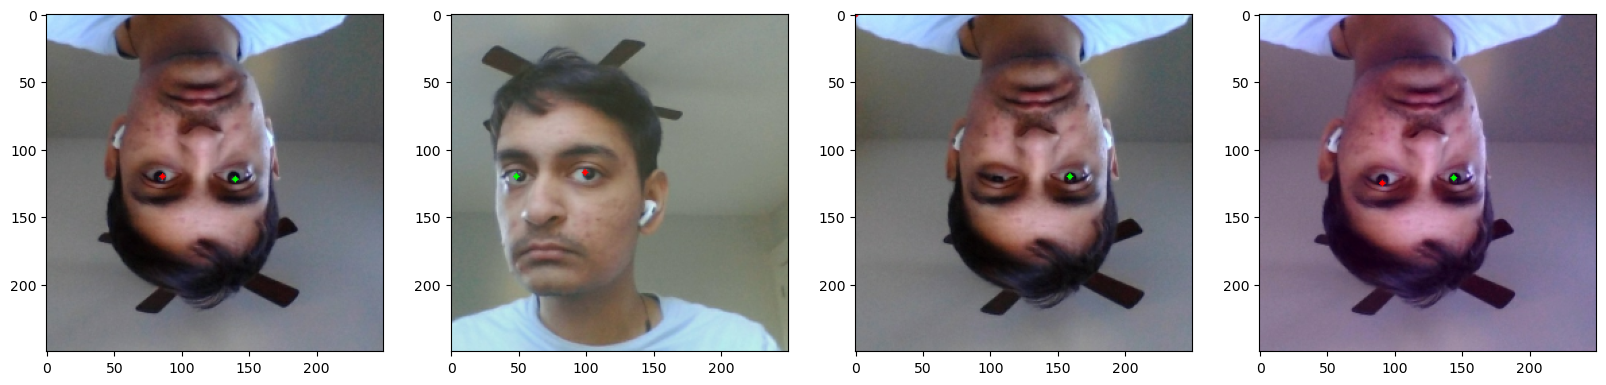

In [50]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

### Model build

In [54]:
model = Sequential([
    Input(shape = (250,250,3)),
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

234545216/234545216 [==============================] - 7s 0us/step


In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 4)           4

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [57]:
model.compile(optimizer,loss)

In [58]:
x, y = train.as_numpy_iterator().next()

In [59]:
scores = model.predict(x)

1/1 [==============================] - 10s 10s/step


In [60]:
scores

array([[ 0.22352256,  0.96274453, -1.4385264 , -0.5292074 ],
       [ 0.26395413,  1.2668644 , -1.9841619 , -1.1784568 ],
       [ 0.32780164,  0.45349807, -1.702487  , -0.4768684 ],
       [ 0.3067795 ,  1.0123454 , -2.0005193 , -0.49877888],
       [ 1.0364641 , -0.3060915 , -1.829835  , -1.4847753 ],
       [ 0.11757061,  0.414932  , -0.9929737 , -1.4889872 ],
       [ 0.2523644 ,  0.23972322, -1.9062917 , -1.850344  ],
       [ 0.8746064 ,  0.6377122 , -2.4433162 , -1.3731921 ],
       [ 0.19738665,  0.29372847, -2.1984138 , -0.88228905],
       [ 0.86936367,  0.9425591 , -1.0549374 , -2.273165  ],
       [ 1.1115607 ,  0.31825343, -1.0293126 , -1.2741377 ],
       [ 0.40684086,  0.3497037 , -1.3922845 , -0.7339281 ],
       [ 0.5869424 ,  0.8934911 , -2.1086738 , -0.5121473 ],
       [ 0.14749184, -0.09802267, -1.0948156 , -1.5179108 ],
       [ 0.27000272,  0.15965885, -0.86429185, -0.4313133 ],
       [ 0.86399966,  0.16830054, -1.1513952 , -1.7091674 ]],
      dtype=float32)

In [62]:
history = model.fit(train,epochs = 10,validation_data = val)

Epoch 1/10


KeyboardInterrupt: 